In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read data

In [3]:
import os


def symbol_to_path(symbol, base_dir='data'):
    """Return csv file path given ticker symbol"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files"""
    df = pd.DataFrame(index=dates)
    
        
    for symbol in symbols:
        df_temp = pd.read_csv(
            symbol_to_path(symbol),
            index_col='Date',
            parse_dates=True,
            usecols=['Date', 'Adj Close'],
            na_values=['nan'])
    
        # rename to prevent crashing
        df_temp = df_temp.rename(columns={'Adj Close': symbol})

        # Join
        df = df.join(df_temp)

    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    return df


def plot_data(df, title="Stock prices", xlabel='Date', ylabel='Prices'):
    """Plot stock prices with a custom title and meaningful axis labels"""
    ax = df.plot(title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()

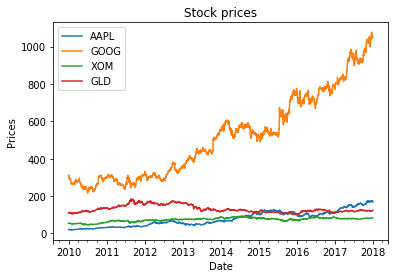

In [4]:
dates = pd.date_range('2010-01-01', '2017-12-31')
symbols = ['AAPL', 'GOOG', 'XOM', 'GLD']

df = get_data(symbols, dates)
plot_data(df)

In [5]:
df.head()

,AAPL,GOOG,XOM,GLD
2010-01-01,20.696495,311.349976,54.068794,109.800003
2010-01-02,20.696495,311.349976,54.068794,109.800003
2010-01-03,20.696495,311.349976,54.068794,109.800003
2010-01-04,20.696495,311.349976,54.068794,109.800003
2010-01-05,20.732277,309.978882,54.279907,109.699997


## Normalized data

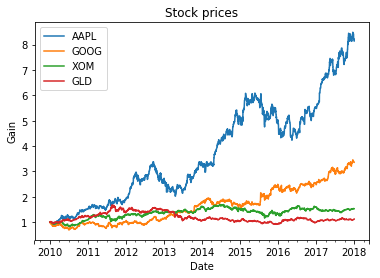

In [6]:
df = df/df.iloc[0, :]

ax = df.plot(title='Stock prices')
ax.set_xlabel('Date')
ax.set_ylabel('Gain')

plt.show()

In [41]:
df.head()

,AAPL,GOOG,XOM,GLD
2010-01-01,1.000000,1.000000,1.000000,1.000000
2010-01-02,1.000000,1.000000,1.000000,1.000000
2010-01-03,1.000000,1.000000,1.000000,1.000000
2010-01-04,1.000000,1.000000,1.000000,1.000000
2010-01-05,1.001729,0.995596,1.003905,0.999089


## APIs

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

# feature engineering
def generate_lag(dataframe, lags):
    lag_df = dataframe.copy()
    
    # Add lag values
    lag_values = [lag_df]
    for i in range(1,(lags + 1)):
        lag_values.append(lag_df.shift(i))
    lag_df = pd.concat(lag_values, axis=1)

    # Rename
    columns = ['t']
    for i in range(1,(lags + 1)):
        columns.append('t-' + str(i))
    lag_df.columns = columns

    # Remove Nan
    lag_df = lag_df[lags:]
    
    return lag_df


def plot_correlation(dataframe, lags):
    plt.figure(1)
    for i in range(1,(lags + 1)):
        ax = plt.subplot(240 + i)
        ax.set_title('t vs t-' + str(i))
        plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
    plt.show()

In [9]:
# Linear Regression
from sklearn.linear_model import LinearRegression

def split_dataset(dataset, split_percentage=0.7):
    train_size = int(len(dataset) * split_percentage)
    return dataset[1:train_size], dataset[train_size:]


def Linear_Regression_predict(train_X, train_y, test_X):
    model = LinearRegression()
    model.fit(train_X, train_y)
    
    return model.predict(test_X)


def Linear_Regression_grid_search(train_X, train_y, valid_X, valid_y, lag_values):
    best_rmse = float("inf")
    best_lag = None
    
    for lag in lag_values:
        predictions = Linear_Regression_predict(train_X[:, :lag], train_y, valid_X[:, :lag])
        rmse = sqrt(mean_squared_error(valid_y, predictions))
        print 'Currently testing lag =', lag, '----- rmse =', rmse
        
        # Find best rmse
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
    return best_lag, best_rmse

In [10]:
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

def train_ARIMA(train, test, orders):
    history = [x for x in train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, order=orders)
        model_fit = model.fit(disp=0)
        
        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)

        obs = test[t]
        history.append(obs)

    return predictions


def grid_search_ARIMA(train, test, p_values, d_values, q_values):
    best_rmse = float("inf")
    best_orders = None  
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                orders = (p,d,q)
                try:
                    predictions = train_ARIMA(train, test, orders)
                    rmse = sqrt(mean_squared_error(test, predictions))
                    print 'Currently testing (p,d,q) =', orders, '----- rmse =', rmse
                    
                    # Find best rmse
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_orders = orders
                except:
                    continue

    return best_orders, best_rmse

C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# AAPL

## Linear Regression

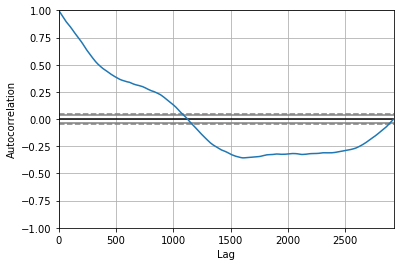

In [11]:
autocorrelation_plot(df['AAPL']);

In [12]:
AAPL_stock = generate_lag(df['AAPL'], 7)
AAPL_stock.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7
2010-01-08,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000,1.000000,1.000000
2010-01-09,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000,1.000000
2010-01-10,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000
2010-01-11,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000
2010-01-12,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729


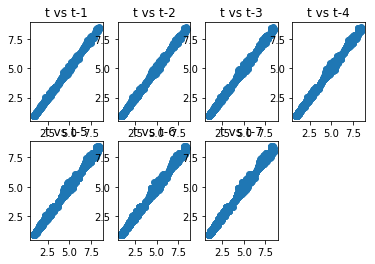

In [13]:
plot_correlation(AAPL_stock, 7)

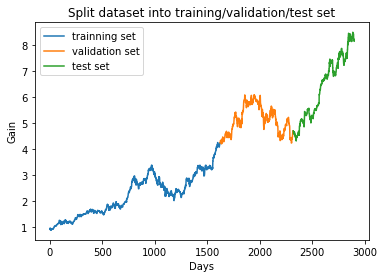

In [14]:
AAPL_stock = generate_lag(df['AAPL'], 20)
dataset = AAPL_stock.values

# Split train-test
train_valid_set, test_set = split_dataset(
    dataset,
    split_percentage=0.8)

# Split train-validation
train_set, valid_set = split_dataset(
    train_valid_set,
    split_percentage=0.7)

train_X, train_y = train_set[:, 1:], train_set[:, 0]
valid_X, valid_y = valid_set[:, 1:], valid_set[:, 0]
test_X, test_y = test_set[:, 1:], test_set[:, 0]


plt.plot(train_y, label='trainning set')
plt.plot([None]*len(train_y) + [x for x in valid_y], label='validation set')
plt.plot([None]*(len(train_y)+len(valid_y)) + [x for x in test_y], label='test set')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set')
plt.legend();

In [15]:
# Find best lag value
lag_values = range(1, 21)
best_lag, best_rmse = Linear_Regression_grid_search(
    train_X, train_y,
    valid_X, valid_y,
    lag_values)

Currently testing lag = 1 ----- rmse = 0.0681184299485
Currently testing lag = 2 ----- rmse = 0.0681223257362
Currently testing lag = 3 ----- rmse = 0.06815698406
Currently testing lag = 4 ----- rmse = 0.0681397973319
Currently testing lag = 5 ----- rmse = 0.0681668500541
Currently testing lag = 6 ----- rmse = 0.0680510359783
Currently testing lag = 7 ----- rmse = 0.0680368919466
Currently testing lag = 8 ----- rmse = 0.0681167632127
Currently testing lag = 9 ----- rmse = 0.0681144323532
Currently testing lag = 10 ----- rmse = 0.0682450179183
Currently testing lag = 11 ----- rmse = 0.0682020982234
Currently testing lag = 12 ----- rmse = 0.0682066932863
Currently testing lag = 13 ----- rmse = 0.068346349801
Currently testing lag = 14 ----- rmse = 0.0686007666681
Currently testing lag = 15 ----- rmse = 0.0685934882764
Currently testing lag = 16 ----- rmse = 0.0686576451934
Currently testing lag = 17 ----- rmse = 0.0686604377645
Currently testing lag = 18 ----- rmse = 0.0686682514038
Curr

In [16]:
print('Best lag value: %d, validation rmse: %.3f' % (best_lag, best_rmse))

Best lag value: 7, validation rmse: 0.068


In [17]:
# Predict
predictions = Linear_Regression_predict(train_X[:, :best_lag], train_y, test_X[:, :best_lag])

In [18]:
# Evaluation
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.061


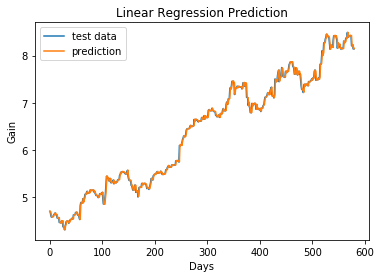

In [19]:
# Plotting
plt.title('Linear Regression Prediction')
plt.plot(test_y, label='test data')
plt.plot(predictions, label='prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

## ARIMA Model for Forecasting

In [19]:
p_values = range(6)
d_values = range(3)
q_values = range(3)

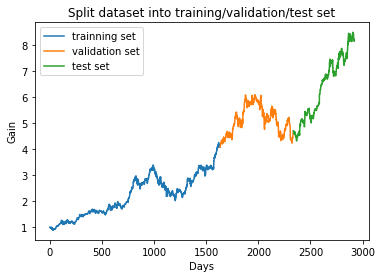

In [41]:
# Split dataset
dataset = df['AAPL'].values 
train_valid, test = split_dataset(
    dataset,
    split_percentage=0.8)
train, valid = split_dataset(
    train_valid,
    split_percentage=0.7)

plt.plot(train, label='trainning set')
plt.plot([None]*len(train) + [x for x in valid], label='validation set');
plt.plot([None]*(len(train)+len(valid)) + [x for x in test], label='test set')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set')
plt.legend();

In [21]:
# Find best orders (p,d,q)
best_orders, best_rmse = grid_search_ARIMA(
    train, valid,
    p_values, d_values, q_values
)

Currently testing (p,d,q) = (0, 0, 0) ----- rmse = 2.48364131894
Currently testing (p,d,q) = (0, 0, 1) ----- rmse = 1.26650933811
Currently testing (p,d,q) = (0, 1, 0) ----- rmse = 0.0679057555661
Currently testing (p,d,q) = (0, 1, 1) ----- rmse = 0.0679954382993
Currently testing (p,d,q) = (0, 1, 2) ----- rmse = 0.0680501205292
Currently testing (p,d,q) = (0, 2, 0) ----- rmse = 0.0959062918676
Currently testing (p,d,q) = (0, 2, 1) ----- rmse = 0.067961162253
Currently testing (p,d,q) = (1, 0, 0) ----- rmse = 0.0678983071
Currently testing (p,d,q) = (1, 1, 0) ----- rmse = 0.0679942677575
Currently testing (p,d,q) = (1, 2, 0) ----- rmse = 0.0837961125124
Currently testing (p,d,q) = (2, 1, 0) ----- rmse = 0.0680524002794
Currently testing (p,d,q) = (2, 2, 0) ----- rmse = 0.0783914395604
Currently testing (p,d,q) = (3, 1, 0) ----- rmse = 0.0680730399881
Currently testing (p,d,q) = (3, 1, 1) ----- rmse = 0.0680880439241
Currently testing (p,d,q) = (3, 2, 0) ----- rmse = 0.0759859093161
Cur

In [22]:
print 'Best order (p,d,q): ', best_orders
print 'validation rmse: %.3f' % best_rmse

Best order (p,d,q):  (1, 0, 0)
validation rmse: 0.068


In [35]:
# predict based on best orders
predictions = train_ARIMA(train, test, best_orders)

In [36]:
# Evaluate
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.066


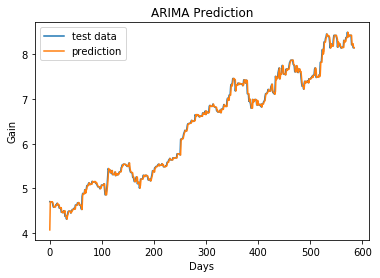

In [37]:
# Plotting
plt.plot(test, label='test data')
plt.plot(predictions, label='prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

# GOOG

## Linear Regression

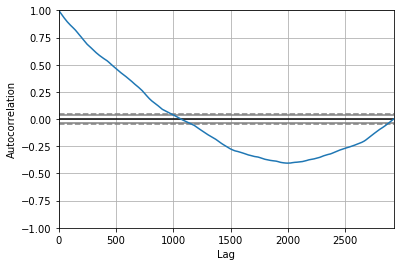

In [56]:
autocorrelation_plot(df['GOOG']);

In [27]:
GOOG_stock = generate_lag(df['GOOG'], 7)
GOOG_stock.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7
2010-01-08,0.960542,0.947906,0.970499,0.995596,1.000000,1.000000,1.000000,1.000000
2010-01-09,0.960542,0.960542,0.947906,0.970499,0.995596,1.000000,1.000000,1.000000
2010-01-10,0.960542,0.960542,0.960542,0.947906,0.970499,0.995596,1.000000,1.000000
2010-01-11,0.959091,0.960542,0.960542,0.960542,0.947906,0.970499,0.995596,1.000000
2010-01-12,0.942130,0.959091,0.960542,0.960542,0.960542,0.947906,0.970499,0.995596


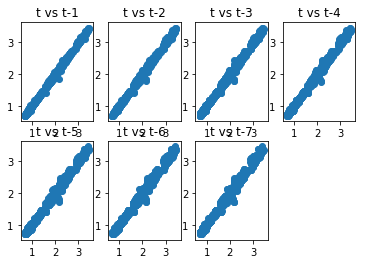

In [28]:
plot_correlation(GOOG_stock, 7)

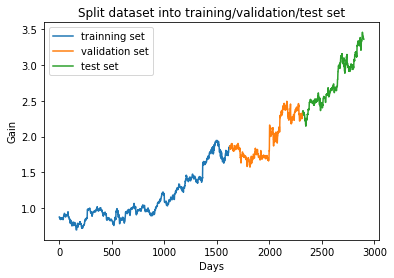

In [48]:
GOOG_stock = generate_lag(df['GOOG'], 20)
dataset = GOOG_stock.values

# Split train-test
train_valid_set, test_set = split_dataset(
    dataset,
    split_percentage=0.8)

# Split train-validation
train_set, valid_set = split_dataset(
    train_valid_set,
    split_percentage=0.7)

train_X, train_y = train_set[:, 1:], train_set[:, 0]
valid_X, valid_y = valid_set[:, 1:], valid_set[:, 0]
test_X, test_y = test_set[:, 1:], test_set[:, 0]

plt.title('Split dataset into trainning/validation/test set')
plt.plot(train_y, label='trainning set')
plt.plot([None]*len(train_y) + [x for x in valid_y], label='validation set')
plt.plot([None]*(len(train_y)+len(valid_y)) + [x for x in test_y], label='test set')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set')
plt.legend();


In [49]:
# Find best lag value
lag_values = range(1, 21)
best_lag, best_rmse = Linear_Regression_grid_search(
    train_X, train_y,
    valid_X, valid_y,
    lag_values)

Currently testing lag = 1 ----- rmse = 0.0270712097821
Currently testing lag = 2 ----- rmse = 0.0270962223962
Currently testing lag = 3 ----- rmse = 0.0271070371629
Currently testing lag = 4 ----- rmse = 0.0271183208343
Currently testing lag = 5 ----- rmse = 0.0271467362801
Currently testing lag = 6 ----- rmse = 0.0271250303741
Currently testing lag = 7 ----- rmse = 0.0271297494142
Currently testing lag = 8 ----- rmse = 0.0271481920086
Currently testing lag = 9 ----- rmse = 0.0271598861999
Currently testing lag = 10 ----- rmse = 0.0271572507679
Currently testing lag = 11 ----- rmse = 0.027195584376
Currently testing lag = 12 ----- rmse = 0.0272081369968
Currently testing lag = 13 ----- rmse = 0.0271802708367
Currently testing lag = 14 ----- rmse = 0.0272160274379
Currently testing lag = 15 ----- rmse = 0.0272342189008
Currently testing lag = 16 ----- rmse = 0.0272397083445
Currently testing lag = 17 ----- rmse = 0.0272397095292
Currently testing lag = 18 ----- rmse = 0.0272527709134
Cu

In [50]:
print('Best lag value: %d, validation rmse: %.3f' % (best_lag, best_rmse))

Best lag value: 1, validation rmse: 0.027


In [51]:
# Predict
predictions = Linear_Regression_predict(train_X[:, :best_lag], train_y, test_X[:, :best_lag])

In [52]:
# Evaluation
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.023


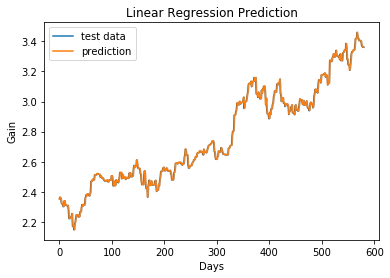

In [53]:
# Plotting
plt.title('Linear Regression Prediction')
plt.plot(test_y, label='test data')
plt.plot(predictions, label='prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

## ARIMA Model for Forecasting

In [35]:
p_values = range(6)
d_values = range(3)
q_values = range(3)

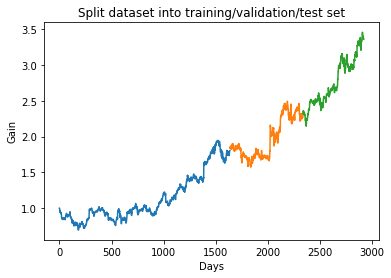

In [66]:
# Split dataset
dataset = df['GOOG'].values 
train_valid, test = split_dataset(
    dataset,
    split_percentage=0.8)
train, valid = split_dataset(
    train_valid,
    split_percentage=0.7)

plt.plot(train)
plt.plot([None]*len(train) + [x for x in valid]);
plt.plot([None]*(len(train)+len(valid)) + [x for x in test])
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set');

In [37]:
# Find best orders (p,d,q)
best_orders, best_rmse = grid_search_ARIMA(
    train, valid,
    p_values, d_values, q_values
)

Currently testing (p,d,q) = (0, 0, 0) ----- rmse = 0.753118608255
Currently testing (p,d,q) = (0, 0, 1) ----- rmse = 0.384982256058
Currently testing (p,d,q) = (0, 1, 0) ----- rmse = 0.0270289618314
Currently testing (p,d,q) = (0, 1, 1) ----- rmse = 0.0270520961681
Currently testing (p,d,q) = (0, 1, 2) ----- rmse = 0.0270707223103
Currently testing (p,d,q) = (0, 2, 0) ----- rmse = 0.0372853491481
Currently testing (p,d,q) = (0, 2, 1) ----- rmse = 0.0270529836501
Currently testing (p,d,q) = (1, 0, 0) ----- rmse = 0.0270465562264
Currently testing (p,d,q) = (1, 1, 0) ----- rmse = 0.0270534572671
Currently testing (p,d,q) = (1, 2, 0) ----- rmse = 0.0330830503564
Currently testing (p,d,q) = (1, 2, 1) ----- rmse = 0.0271010683707
Currently testing (p,d,q) = (1, 2, 2) ----- rmse = 0.0270737214637
Currently testing (p,d,q) = (2, 1, 0) ----- rmse = 0.0270730899338
Currently testing (p,d,q) = (2, 2, 0) ----- rmse = 0.0311615685108
Currently testing (p,d,q) = (3, 1, 0) ----- rmse = 0.02710632013

In [38]:
print 'Best order (p,d,q): ', best_orders
print 'validation rmse: %.3f' % best_rmse

Best order (p,d,q):  (0, 1, 0)
validation rmse: 0.027


In [59]:
# predict based on best orders
predictions = train_ARIMA(train, test, best_orders)

In [60]:
# Evaluate
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


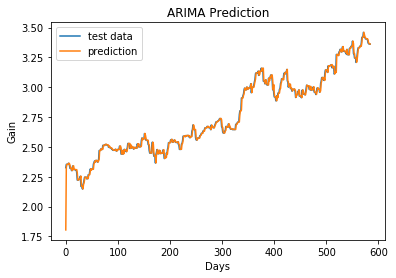

In [61]:
# Plotting
plt.plot(test, label='test data')
plt.plot(predictions, label='prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

# XOM

## Linear Regression

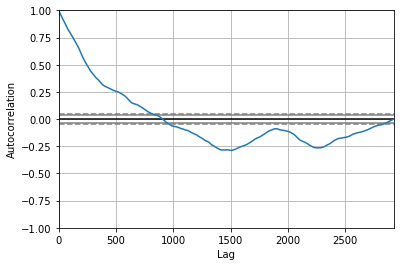

In [42]:
autocorrelation_plot(df['XOM']);

In [67]:
XOM_stock = generate_lag(df['XOM'], 7)
XOM_stock.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7
2010-01-08,1.005351,1.009400,1.012581,1.003905,1.000000,1.000000,1.000000,1.000000
2010-01-09,1.005351,1.005351,1.009400,1.012581,1.003905,1.000000,1.000000,1.000000
2010-01-10,1.005351,1.005351,1.005351,1.009400,1.012581,1.003905,1.000000,1.000000
2010-01-11,1.016630,1.005351,1.005351,1.005351,1.009400,1.012581,1.003905,1.000000
2010-01-12,1.011569,1.016630,1.005351,1.005351,1.005351,1.009400,1.012581,1.003905


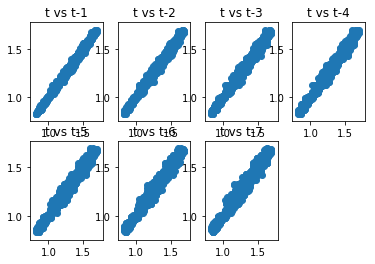

In [68]:
plot_correlation(XOM_stock, 7)

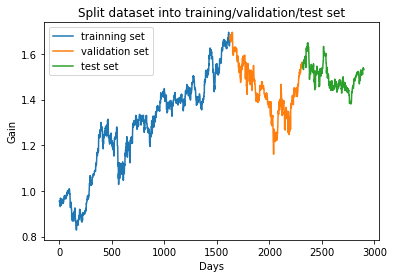

In [69]:
XOM_stock = generate_lag(df['XOM'], 20)
dataset = XOM_stock.values

# Split train-test
train_valid_set, test_set = split_dataset(
    dataset,
    split_percentage=0.8)

# Split train-validation
train_set, valid_set = split_dataset(
    train_valid_set,
    split_percentage=0.7)

train_X, train_y = train_set[:, 1:], train_set[:, 0]
valid_X, valid_y = valid_set[:, 1:], valid_set[:, 0]
test_X, test_y = test_set[:, 1:], test_set[:, 0]

plt.title('Split dataset into trainning/validation/test set')
plt.plot(train_y, label='trainning set')
plt.plot([None]*len(train_y) + [x for x in valid_y], label='validation set')
plt.plot([None]*(len(train_y)+len(valid_y)) + [x for x in test_y], label='test set')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set')
plt.legend();


In [70]:
# Find best lag value
lag_values = range(1, 21)
best_lag, best_rmse = Linear_Regression_grid_search(
    train_X, train_y,
    valid_X, valid_y,
    lag_values)

Currently testing lag = 1 ----- rmse = 0.0156630476089
Currently testing lag = 2 ----- rmse = 0.0156717714938
Currently testing lag = 3 ----- rmse = 0.0156792862471
Currently testing lag = 4 ----- rmse = 0.0156201025828
Currently testing lag = 5 ----- rmse = 0.0156202608471
Currently testing lag = 6 ----- rmse = 0.0156616973656
Currently testing lag = 7 ----- rmse = 0.0157712918632
Currently testing lag = 8 ----- rmse = 0.0156922823237
Currently testing lag = 9 ----- rmse = 0.0156933008308
Currently testing lag = 10 ----- rmse = 0.0157168787333
Currently testing lag = 11 ----- rmse = 0.015735067481
Currently testing lag = 12 ----- rmse = 0.0157366706879
Currently testing lag = 13 ----- rmse = 0.0157218757558
Currently testing lag = 14 ----- rmse = 0.0157373552811
Currently testing lag = 15 ----- rmse = 0.0157346594027
Currently testing lag = 16 ----- rmse = 0.0157341672806
Currently testing lag = 17 ----- rmse = 0.0157600997389
Currently testing lag = 18 ----- rmse = 0.0157630602455
Cu

In [71]:
print('Best lag value: %d, validation rmse: %.3f' % (best_lag, best_rmse))

Best lag value: 4, validation rmse: 0.016


In [72]:
# Predict
predictions = Linear_Regression_predict(train_X[:, :best_lag], train_y, test_X[:, :best_lag])

In [73]:
# Evaluation
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


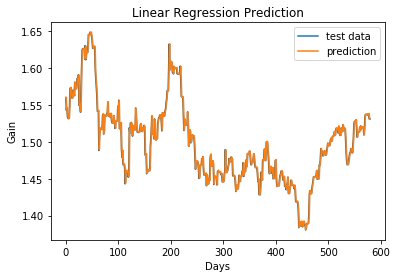

In [74]:
# Plotting
plt.title('Linear Regression Prediction')
plt.plot(test_y, label='test data')
plt.plot(predictions, label='prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

## ARIMA Model for Forecasting

In [51]:
p_values = range(6)
d_values = range(3)
q_values = range(3)

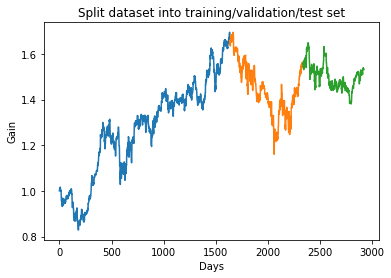

In [75]:
# Split dataset
dataset = df['XOM'].values 
train_valid, test = split_dataset(
    dataset,
    split_percentage=0.8)
train, valid = split_dataset(
    train_valid,
    split_percentage=0.7)

plt.plot(train)
plt.plot([None]*len(train) + [x for x in valid]);
plt.plot([None]*(len(train)+len(valid)) + [x for x in test])
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into training/validation/test set');

In [53]:
# Find best orders (p,d,q)
best_orders, best_rmse = grid_search_ARIMA(
    train, valid,
    p_values, d_values, q_values
)

Currently testing (p,d,q) = (0, 0, 0) ----- rmse = 0.188192530686
Currently testing (p,d,q) = (0, 0, 1) ----- rmse = 0.101161815167
Currently testing (p,d,q) = (0, 1, 0) ----- rmse = 0.015653355254
Currently testing (p,d,q) = (0, 1, 1) ----- rmse = 0.0156653663964
Currently testing (p,d,q) = (0, 1, 2) ----- rmse = 0.0156785785341
Currently testing (p,d,q) = (0, 2, 0) ----- rmse = 0.0219727365571
Currently testing (p,d,q) = (0, 2, 1) ----- rmse = 0.0156665663763
Currently testing (p,d,q) = (0, 2, 2) ----- rmse = 0.0156780314518
Currently testing (p,d,q) = (1, 0, 0) ----- rmse = 0.0156355420041
Currently testing (p,d,q) = (1, 0, 1) ----- rmse = 0.0156468980734
Currently testing (p,d,q) = (1, 0, 2) ----- rmse = 0.0156606019379
Currently testing (p,d,q) = (1, 1, 0) ----- rmse = 0.0156661345251
Currently testing (p,d,q) = (1, 2, 0) ----- rmse = 0.019171797324
Currently testing (p,d,q) = (1, 2, 1) ----- rmse = 0.0156964790968
Currently testing (p,d,q) = (1, 2, 2) ----- rmse = 0.0156731001899

In [54]:
print 'Best order (p,d,q): ', best_orders
print 'validation rmse: %.3f' % best_rmse

Best order (p,d,q):  (4, 0, 2)
validation rmse: 0.016


In [78]:
# predict based on best orders
predictions = train_ARIMA(train, test, best_orders)

In [79]:
# Evaluate
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.012


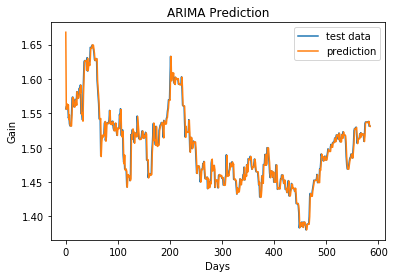

In [80]:
# Plotting
plt.plot(test, label='test data')
plt.plot(predictions, label='prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

# Experiments

### Linear Regression

In [81]:
predictions = Linear_Regression_predict(train_X[:, :best_lag], train_y, test_X[:, :best_lag])

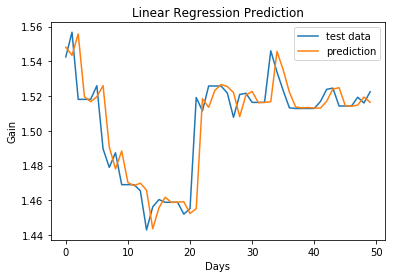

In [82]:
# Plotting
plt.title('Linear Regression Prediction')
plt.plot(test_y[100:150], label='test data')
plt.plot(predictions[100:150], label='prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

### ARIMA

In [83]:
predictions = train_ARIMA(train, test, best_orders)

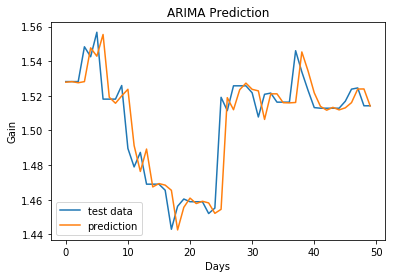

In [84]:
plt.title('ARIMA Prediction')
plt.plot(test[100:150], label='test data')
plt.plot(predictions[100:150], label='prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend();

## Remove trend

### Differencing

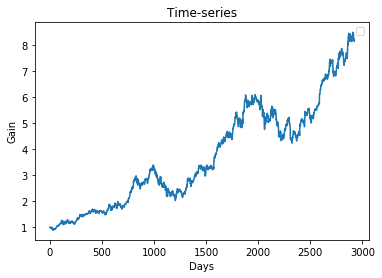

In [106]:
# Split dataset
X = df['AAPL'].values

plt.plot(X)
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Time-series')
plt.legend();

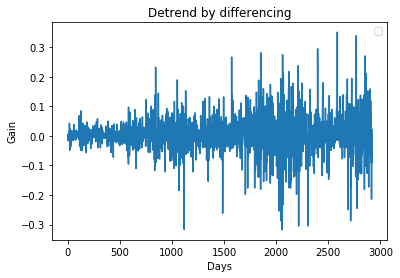

In [107]:
X_detrend = [X[i] - X[i-1] for i in range(1, len(X))]

plt.plot(X_detrend)
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Detrend by differencing');

### Model fitting

In [95]:
X = df['AAPL'].values

In [96]:
from sklearn.linear_model import LinearRegression

y = X

X = [i for i in range(0, len(X))]
X = np.reshape(X, (len(X), 1))


model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

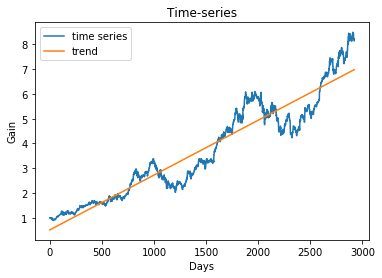

In [109]:
# plot trend
plt.plot(y, label='time series')
plt.plot(trend, label='trend')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Time-series')
plt.legend();

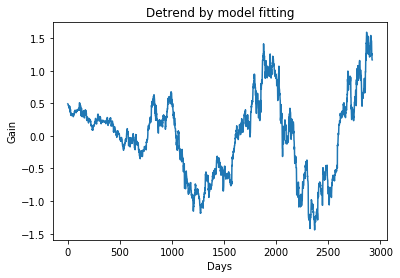

In [110]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(X))]

# plot detrended
plt.plot(detrended)
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Detrend by model fitting');

## Robustness

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

# feature engineering
def generate_lag(dataframe, lags):
    lag_df = dataframe.copy()
    
    # Add lag values
    lag_values = [lag_df]
    for i in range(1,(2*lags + 1)):
        lag_values.append(lag_df.shift(i))
    lag_df = pd.concat(lag_values, axis=1)

    # Rename
    columns = []
    for i in range(0,lags):
        columns.append('t+' + str(lags-i))
    columns.append('t')
    for i in range(lags+1, 2*lags + 1):
        columns.append('t-' + str(i-lags))   
        
    lag_df.columns = columns

    # Remove Nan
    lag_df = lag_df[2*lags:]
    
    return lag_df


def plot_correlation(dataframe, lags):
    plt.figure(1)
    for i in range(1,(lags + 1)):
        ax = plt.subplot(240 + i)
        ax.set_title('t vs t-' + str(i))
        plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
    plt.show()

In [39]:
AAPL_stock = generate_lag(df['AAPL'], 7)
AAPL_stock.head()

,t+7,t+6,t+5,t+4,t+3,t+2,t+1,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7
2010-01-15,0.962245,0.978599,0.984300,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000,1.000000,1.000000
2010-01-16,0.962245,0.962245,0.978599,0.984300,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000,1.000000
2010-01-17,0.962245,0.962245,0.962245,0.978599,0.984300,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000,1.000000
2010-01-18,0.962245,0.962245,0.962245,0.962245,0.978599,0.984300,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729,1.000000
2010-01-19,1.004813,0.962245,0.962245,0.962245,0.962245,0.978599,0.984300,0.970609,0.981777,0.990514,0.990514,0.990514,0.983973,0.985795,1.001729


### Predict t+n based on t-1,t-2...

In [53]:
def Linear_Regression_grid_search(train_X, train_y, valid_X, valid_y, lag_values):
    best_rmse = float("inf")
    best_lag = None
    
    for lag in lag_values:
        predictions = Linear_Regression_predict(train_X[:, :lag], train_y, valid_X[:, :lag])
        rmse = sqrt(mean_squared_error(valid_y, predictions))
#         print 'Currently testing lag =', lag, '----- rmse =', rmse
        
        # Find best rmse
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
    return best_lag, best_rmse

In [57]:
AAPL_stock = generate_lag(df['AAPL'], 20)
dataset = AAPL_stock.values

for n in range(8):
    # Split train-test
    train_valid_set, test_set = split_dataset(
        dataset,
        split_percentage=0.8)

    # Split train-validation
    train_set, valid_set = split_dataset(
        train_valid_set,
        split_percentage=0.7)

    train_X, train_y = train_set[:, 21:], train_set[:, 20-n]
    valid_X, valid_y = valid_set[:, 21:], valid_set[:, 20-n]
    test_X, test_y = test_set[:, 21:], test_set[:, 20-n]

    # Find best lag value
    lag_values = range(1, 21)
    best_lag, best_rmse = Linear_Regression_grid_search(
        train_X, train_y,
        valid_X, valid_y,
        lag_values)
    
    print 'Predict t +', n
    print('Best lag value: %d, validation rmse: %.3f' % (best_lag, best_rmse))

    # Predict
    predictions = Linear_Regression_predict(train_X[:, :best_lag], train_y, test_X[:, :best_lag])

    # Evaluation
    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test RMSE: %.3f' % rmse)
    print('')

Predict t + 0
Best lag value: 7, validation rmse: 0.068
Test RMSE: 0.060

Predict t + 1
Best lag value: 6, validation rmse: 0.096
Test RMSE: 0.086

Predict t + 2
Best lag value: 1, validation rmse: 0.117
Test RMSE: 0.106

Predict t + 3
Best lag value: 1, validation rmse: 0.135
Test RMSE: 0.124

Predict t + 4
Best lag value: 1, validation rmse: 0.151
Test RMSE: 0.141

Predict t + 5
Best lag value: 1, validation rmse: 0.164
Test RMSE: 0.156

Predict t + 6
Best lag value: 1, validation rmse: 0.176
Test RMSE: 0.168

Predict t + 7
Best lag value: 1, validation rmse: 0.185
Test RMSE: 0.182

